<h1 align="center">Bibliotheken und Daten laden sowie Spark Session erzeugen</h1>

In [1]:
import pprint as pp
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf

from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, OneHotEncoderEstimator, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


#https://mapr.com/blog/churn-prediction-sparkml/
#Vorgehen: Load -> Extract Feature -> Transformer -> Train Model -> Evaluator


spark = SparkSession\
    .builder\
    .master("local[*]")\
    .appName("predict revenue random forest")\
    .getOrCreate()

dateipfad = "C:\\Users\\AMeinert\\Documents\\Python_Scripts\\projects\\MA\\data\\share\\"
datei_selected_features = "selected_features.csv"


data = spark.read.csv(dateipfad + datei_selected_features, sep=";", inferSchema=True, encoding="ISO-8859-1", header=True)



In [2]:
data.printSchema()

root
 |-- DEM_3_29: double (nullable = true)
 |-- GEB_6_4: double (nullable = true)
 |-- DEM_2_4: double (nullable = true)
 |-- HH_4_4: double (nullable = true)
 |-- WHG_4_2: double (nullable = true)
 |-- osm_nodes_counter: integer (nullable = true)
 |-- BEV_INSGESAMT: integer (nullable = true)
 |-- BEV_JE_QM: integer (nullable = true)
 |-- FLAECHE_QM: double (nullable = true)
 |-- ANTEIL_ARBEITSLOSE: double (nullable = true)
 |-- ANTEIL_ARBEITSLOSE_ALTER_15_24: double (nullable = true)
 |-- ANTEIL_SIEDLUNG_VERKEHR: double (nullable = true)
 |-- EINK_JE_EINW: double (nullable = true)
 |-- WHG_6_5: double (nullable = true)
 |-- BESIEDLUNGSSCHLUESSEL: integer (nullable = true)
 |-- REGIONSTYP: string (nullable = true)
 |-- revenue_sum1: double (nullable = true)
 |-- revenue_sum2: double (nullable = true)
 |-- revenue_avg2: double (nullable = true)
 |-- revenue_avg1_per_head: double (nullable = true)
 |-- revenue_avg2_per_head: double (nullable = true)
 |-- revenue_avg1: double (nullable 

9118

<img src="https://mapr.com/blog/churn-prediction-sparkml/assets/Picture11.png">

<h1 align="center">KONFIGURATION DES MODELLS</h1>

<h2>Random Forest Tuning Parameters (hyperparameter-tuning)</h2>
<div>The first two parameters we mention are the most important, and tuning them can often improve performance:
    
<ul><b>numTrees</b>: Number of trees in the forest. Increasing the number of trees will decrease the variance in predictions,improving the model’s test-time accuracy. raining time increases roughly linearly in the number of trees.</ul>

<ul><b>maxDepth</b>: Maximum depth of each tree in the forest. ncreasing the depth makes the model more expressive and powerful. However, deep trees take longer to train and are also more prone to overfitting. Ingeneral, it is acceptable to train deeper trees when using random forests than when using a single decision tree. One tree is more likely to overfit than a random forest (because of the variance reduction from averaging multiple trees in the forest).</ul>
</div>
<div>
The next two parameters generally do not require tuning. However, they can be tuned to speed up training.

<ul><b>subsamplingRate:</b> This parameter specifies the size of the dataset used for training each tree in the forest, as a fraction of the size of the original dataset. The default (1.0) is recommended, but decreasing this fraction can speed up training.</ul>

<ul><b>featureSubsetStrategy:</b> Number of features to use as candidates for splitting at each tree node. The number is specified as a fraction or function of the total number of features. Decreasing this number will speed up training, but can sometimes impact performance if too low.</ul>
</div>


In [10]:
test_set_size = 0.3
seed = 42

input_feat = ["DEM_3_29", 
              "GEB_6_4",
              "DEM_2_4",
              "HH_4_4",
              "WHG_4_2",
              "osm_nodes_counter",
              "BEV_INSGESAMT",
              "BEV_JE_QM",
              "FLAECHE_QM",
              "ANTEIL_ARBEITSLOSE",
              "ANTEIL_ARBEITSLOSE_ALTER_15_24",
              "ANTEIL_SIEDLUNG_VERKEHR",
              "EINK_JE_EINW",
              "WHG_6_5",
              "BESIEDLUNGSSCHLUESSEL",
              "REGIONSTYP"]

pred_col = "revenue_avg1"

rf = RandomForestRegressor(featuresCol="features", seed=seed)

"""
paramGrid = ParamGridBuilder()\
    .addGrid(rf.subsamplingRate, [0.7, 0.8, 0.9, 1.0])\
    .addGrid(rf.numTrees, [3, 4, 5, 6, 7, 10, 15, 30, 60, 120, 200])\
    .addGrid(rf.maxDepth, [2, 3, 4, 5, 6])\
    .addGrid(rf.featureSubsetStrategy, ["all", "onethird", "sqrt"])\
    .build()
"""
    
paramGrid = ParamGridBuilder()\
    .addGrid(rf.subsamplingRate, [0.7, 0.8, 0.9, 1.0])\
    .addGrid(rf.numTrees, [3, 7, 10, 120])\
    .addGrid(rf.maxDepth, [2, 5])\
    .addGrid(rf.featureSubsetStrategy, ["all", "onethird"])\
    .build()
    

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)  # use 3+ folds in practice


<h1 align="center">FEATURE TRANSFORMATION</h1>
<ol>
    <li>Überführung der kategorialen Variabeln in numerische Typen (StringIndexer)</li>
    <li>Kategoriale Variablen (indexiert) in binäre Vektoren (OneHotEncoderEstimator)</li>
    <li>Feature Vektor mit allen Merkmalen erzeugen (VektorAssembler)</li>
</ol>

In [4]:
data_not_null = data.dropna(subset=input_feat)
print("Rows vor Eliminierung der Nullwerte: " + str(data.count()))
print("Rows nach Eliminierung der Nullwerte: " + str(data_not_null.count()))


indexer = StringIndexer(inputCol="REGIONSTYP", outputCol="REGIONSTYP_INDEX")
data_indexed = indexer.fit(data_not_null).transform(data_not_null)

data_indexed.select("REGIONSTYP", "REGIONSTYP_INDEX").show()



Rows vor Eliminierung der Nullwerte: 9571
Rows nach Eliminierung der Nullwerte: 9118
+----------+----------------+
|REGIONSTYP|REGIONSTYP_INDEX|
+----------+----------------+
|     stadt|             1.0|
|     stadt|             1.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|     stadt|             1.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
|       gem|             0.0|
+----------+----------------+
only showing top 20 rows



In [5]:
encoder = OneHotEncoderEstimator(inputCols=["BESIEDLUNGSSCHLUESSEL", "REGIONSTYP_INDEX"],
                                 outputCols=["BESIEDLUNGSSCHLUESSEL_encoded", "REGIONSTYP_encoded"])

data_encoded = encoder.fit(data_indexed).transform(data_indexed)


In [6]:
data_encoded.select("BESIEDLUNGSSCHLUESSEL_encoded", "BESIEDLUNGSSCHLUESSEL", "REGIONSTYP_INDEX","REGIONSTYP_encoded").show()

+-----------------------------+---------------------+----------------+------------------+
|BESIEDLUNGSSCHLUESSEL_encoded|BESIEDLUNGSSCHLUESSEL|REGIONSTYP_INDEX|REGIONSTYP_encoded|
+-----------------------------+---------------------+----------------+------------------+
|                    (3,[],[])|                    3|             1.0|         (1,[],[])|
|                    (3,[],[])|                    3|             1.0|         (1,[],[])|
|                    (3,[],[])|                    3|             0.0|     (1,[0],[1.0])|
|                    (3,[],[])|                    3|             0.0|     (1,[0],[1.0])|
|                    (3,[],[])|                    3|             0.0|     (1,[0],[1.0])|
|                    (3,[],[])|                    3|             0.0|     (1,[0],[1.0])|
|                    (3,[],[])|                    3|             0.0|     (1,[0],[1.0])|
|                    (3,[],[])|                    3|             0.0|     (1,[0],[1.0])|
|         

In [7]:
input_feat.remove("BESIEDLUNGSSCHLUESSEL")
input_feat.remove("REGIONSTYP")

input_feat.append("BESIEDLUNGSSCHLUESSEL_encoded")
input_feat.append("REGIONSTYP_encoded")
input_feat

['DEM_3_29',
 'GEB_6_4',
 'DEM_2_4',
 'HH_4_4',
 'WHG_4_2',
 'osm_nodes_counter',
 'BEV_INSGESAMT',
 'BEV_JE_QM',
 'FLAECHE_QM',
 'ANTEIL_ARBEITSLOSE',
 'ANTEIL_ARBEITSLOSE_ALTER_15_24',
 'ANTEIL_SIEDLUNG_VERKEHR',
 'EINK_JE_EINW',
 'WHG_6_5',
 'BESIEDLUNGSSCHLUESSEL_encoded',
 'REGIONSTYP_encoded']

In [8]:
vector_assembler = VectorAssembler(
    inputCols=input_feat,
    outputCol="features")


data_vec = vector_assembler.transform(data_encoded)
data_vec.select("features").show(truncate= False)
data_vec.count()

+--------------------------------------------------------------------------------------------------------+
|features                                                                                                |
+--------------------------------------------------------------------------------------------------------+
|[217.0,376.0,4613.0,4088.0,608.0,254.0,13120.0,201.0,65.24,8.4,13.6,10.9,18912.0,317.0,0.0,0.0,0.0,0.0] |
|[384.0,707.0,8764.0,7090.0,1342.0,408.0,20886.0,653.0,31.97,8.4,13.6,10.9,18912.0,323.0,0.0,0.0,0.0,0.0]|
|[6.0,4.0,221.0,191.0,20.0,17.0,599.0,66.0,9.07,8.4,13.6,10.9,18912.0,17.0,0.0,0.0,0.0,1.0]              |
|[21.0,9.0,435.0,283.0,33.0,13.0,1076.0,74.0,14.55,8.4,13.6,10.9,18912.0,12.0,0.0,0.0,0.0,1.0]           |
|[72.0,127.0,1493.0,1227.0,198.0,65.0,4237.0,377.0,11.23,8.4,13.6,10.9,18912.0,96.0,0.0,0.0,0.0,1.0]     |
|[21.0,19.0,529.0,397.0,31.0,22.0,1367.0,148.0,9.21,8.4,13.6,10.9,18912.0,28.0,0.0,0.0,0.0,1.0]          |
|[11.0,12.0,295.0,199.0,18.0,12.0,781

9118

<h1 align="center"> TEST UND TRAININGS DATEN ERZEUGEN <u>FÜR STADT MODELL</u></h1>

In [11]:
prediction_data = data_vec.select("*").where(col(pred_col).isNull())
prediction_data_stadt = prediction_data.select("*").where(col("REGIONSTYP_INDEX") == 1)

learning_data = data_vec.select("*").where(col(pred_col).isNotNull()).withColumnRenamed(pred_col, "label")
learning_data_stadt = learning_data.select("*").where(col("REGIONSTYP_INDEX") == 1)



training_stadt, test_stadt = learning_data_stadt.randomSplit([1 - test_set_size , test_set_size], seed=seed)


display(
    "Rows im gesamten Datensatz:  " + str(data.count()),
    "Rows im Learning-Datensatz (Stadt):  " + str(learning_data_stadt.count()),
    "      Rows im Trainings-Datensatz (Stadt):  " + str(training_stadt.count()),
    "      Rows im Test-Datensatz (Stadt):       " + str(test_stadt.count()),
    "Rows im Prediction-Datensatz (Stadt): " + str(prediction_data_stadt.count())
)


'Rows im gesamten Datensatz:  9571'

'Rows im Learning-Datensatz (Stadt):  1221'

'      Rows im Trainings-Datensatz (Stadt):  846'

'      Rows im Test-Datensatz (Stadt):       375'

'Rows im Prediction-Datensatz (Stadt): 667'

<h1 align="center"> BESTES MODEL AUSWÄHLEN (CrossValidator) UND VALIDIEREN </h1>

In [12]:
cvModel_stadt = crossval.fit(training_stadt)

for i in range(15):
    key = list(cvModel_stadt.bestModel.extractParamMap().keys())[i].name
    value = list(cvModel_stadt.bestModel.extractParamMap().values())[i]
    print(str(key) + " " + str(value))

cacheNodeIds False
checkpointInterval 10
featureSubsetStrategy all
featuresCol features
impurity variance
labelCol label
maxBins 32
maxDepth 5
maxMemoryInMB 256
minInfoGain 0.0
minInstancesPerNode 1
numTrees 120
predictionCol prediction
seed 42
subsamplingRate 1.0


In [13]:
numTrees = 120
maxDepth = 5
maxBins = 32
featureSubsetStrategy = "all" #one-all, sqrt,...
impurity = "variance" #gini
subsamplingRate = 1.0

In [14]:
pipeline = Pipeline(stages=[vector_assembler, rf])

model = pipeline.fit(training_stadt.drop("features"))
rfModel = model.stages[1]

rf = RandomForestRegressor(featuresCol="features", seed=seed, numTrees=numTrees, maxDepth=maxDepth, maxBins=maxBins,
                          featureSubsetStrategy=featureSubsetStrategy, impurity=impurity, subsamplingRate=subsamplingRate)


In [15]:
validation = model.transform(test_stadt.drop("features"))

validation.select("prediction", "label", "features").show(5)


metrics_vali = {}
importance = {}

for metric in ["mae", "mse", "rmse", "r2"]:
    evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName=metric)
    metric_value = evaluator.evaluate(validation)
    metrics_vali.update({metric: str(round(metric_value,2))})


for i in range(len(rfModel.featureImportances)):
    #print( + " " + str(rfModel.featureImportances[i]))
    importance.update({test_stadt.columns[i]: rfModel.featureImportances[i]})
    
    

pp.pprint(metrics_vali)    
rfModel.extractParamMap() 
#rfModel.explainParams() 

pd.Series(index=importance.keys(), data=importance).plot(kind="bar", title="Importance Factor of Input Variables", figsize=(10, 5))

validation.toPandas().sort_values(by=["prediction"]).reset_index().plot(title="prediction/label testset", y=["prediction", "label"], figsize=(10, 5))


+------------------+----------+--------------------+
|        prediction|     label|            features|
+------------------+----------+--------------------+
| 2197621.912517236|1180740.03|[28.0,44.0,814.0,...|
|2576720.7308896207|2805977.82|[30.0,65.0,1323.0...|
|2307238.6830275385|1375374.32|[31.0,41.0,720.0,...|
|2516996.0628314856|1811525.79|[51.0,116.0,1458....|
| 2739141.803059313|1358134.68|[54.0,153.0,1463....|
+------------------+----------+--------------------+
only showing top 5 rows

{'dataset': 'on test set',
 'mae': '1214986.62',
 'mse': '2386634630438.0',
 'r2': '0.89',
 'rmse': '1544873.66'}


C:\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


In [43]:
rfModel.featureImportances

SparseVector(18, {0: 0.0147, 1: 0.0726, 2: 0.0744, 3: 0.0763, 4: 0.1471, 5: 0.4386, 6: 0.1002, 7: 0.0143, 8: 0.0077, 9: 0.0071, 10: 0.0036, 11: 0.015, 12: 0.0145, 13: 0.0057, 15: 0.0062, 16: 0.0018})

In [ ]:
pp.pprint(model.stages[1].toDebugString)

<h1 align="center">VORHERSAGE</h1>

In [ ]:
hh_1_4_median = prediction_data_set.approxQuantile("HH_1_4", [0.5], 0)[0]
prediction = model.transform(prediction_data_set.fillna(hh_1_4_median, subset=["HH_1_4"]))
print(prediction.count())
prediction.select("prediction", "features").show(5)
prediction.select("prediction").collect()


prediction.toPandas().sort_values(by=["prediction"]).reset_index().plot(title="predicted " + pred_col, y=["prediction"])


<h1 align="center"> TEST UND TRAININGS DATEN ERZEUGEN <u>FÜR GEMEINDE MODELL</u></h1>

In [16]:
prediction_data_gemeinde = prediction_data.select("*").where(col("REGIONSTYP_INDEX") == 0)
learning_data_gemeinde = learning_data.select("*").where(col("REGIONSTYP_INDEX") == 0)

training_gemeinde, test_gemeinde = learning_data_gemeinde.randomSplit([1 - test_set_size , test_set_size], seed=seed)


display(
    "Rows im gesamten Gemeinde-Datensatz:  " + str(data.count()),
    "Rows im Learning-Datensatz (Gemeinde):  " + str(learning_data_gemeinde.count()),
    "      Rows im Trainings-Datensatz (Gemeinde):  " + str(training_gemeinde.count()),
    "      Rows im Test-Datensatz (Gemeinde):       " + str(test_gemeinde.count()),
    "Rows im Prediction-Datensatz (Gemeinde): " + str(prediction_data_gemeinde.count())
)


'Rows im gesamten Gemeinde-Datensatz:  9571'

'Rows im Learning-Datensatz (Gemeinde):  604'

'      Rows im Trainings-Datensatz (Gemeinde):  431'

'      Rows im Test-Datensatz (Gemeinde):       173'

'Rows im Prediction-Datensatz (Gemeinde): 6626'

<h1 align="center"> BESTES MODEL AUSWÄHLEN (CrossValidator) UND VALIDIEREN </h1>

In [17]:
cvModel_gemeinde = crossval.fit(training_gemeinde)
for i in range(15):
    key = list(cvModel_gemeinde.bestModel.extractParamMap().keys())[i].name
    value = list(cvModel_gemeinde.bestModel.extractParamMap().values())[i]
    print(str(key) + " " + str(value))

cacheNodeIds False
checkpointInterval 10
featureSubsetStrategy all
featuresCol features
impurity variance
labelCol label
maxBins 32
maxDepth 5
maxMemoryInMB 256
minInfoGain 0.0
minInstancesPerNode 1
numTrees 120
predictionCol prediction
seed 42
subsamplingRate 1.0


In [19]:
numTrees = 120
maxDepth = 5
maxBins = 32
featureSubsetStrategy = "all" #one-all, sqrt,...
impurity = "variance" #gini
subsamplingRate = 1.0

In [20]:
pipeline = Pipeline(stages=[vector_assembler, rf])

model = pipeline.fit(training_gemeinde.drop("features"))
rfModel = model.stages[1]

rf = RandomForestRegressor(featuresCol="features", seed=seed, numTrees=numTrees, maxDepth=maxDepth, maxBins=maxBins,
                          featureSubsetStrategy=featureSubsetStrategy, impurity=impurity, subsamplingRate=subsamplingRate)


+------------------+----------+--------------------+
|        prediction|     label|            features|
+------------------+----------+--------------------+
| 1602312.279783241| 426378.41|[3.0,14.0,113.0,8...|
|1773695.9684142356|1708572.58|[6.0,12.0,307.0,2...|
|3398901.0123755177|2940454.81|[6.0,43.0,299.0,3...|
|2357471.1037367587|3050450.19|[22.0,32.0,921.0,...|
| 2875816.465186937|2517251.91|[24.0,69.0,394.0,...|
+------------------+----------+--------------------+
only showing top 5 rows

{'dataset': 'on test set',
 'mae': '725650.76',
 'mse': '1094401459828.37',
 'r2': '0.84',
 'rmse': '1046136.44'}


C:\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


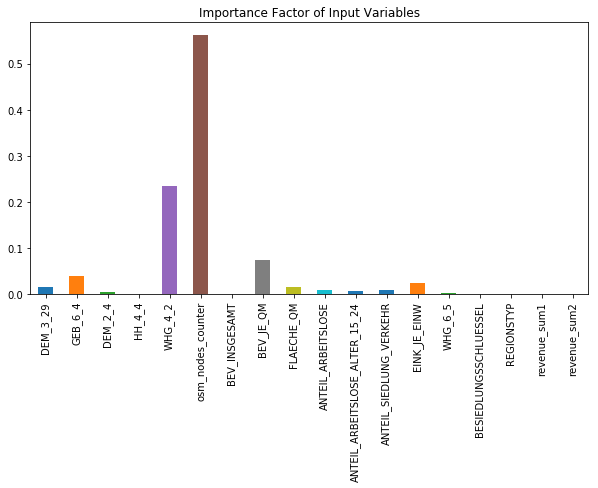

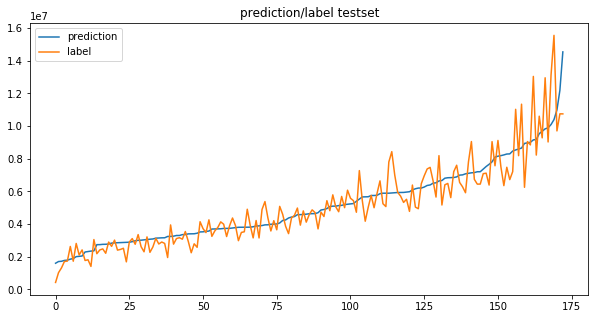

In [21]:
validation = model.transform(test_gemeinde.drop("features"))

validation.select("prediction", "label", "features").show(5)


metrics_vali = {}
importance = {}

for metric in ["mae", "mse", "rmse", "r2"]:
    evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName=metric)
    metric_value = evaluator.evaluate(validation)
    metrics_vali.update({metric: str(round(metric_value,2))})


for i in range(len(rfModel.featureImportances)):
    #print( + " " + str(rfModel.featureImportances[i]))
    importance.update({test_gemeinde.columns[i]: rfModel.featureImportances[i]})
    
    

pp.pprint(metrics_vali)    
rfModel.extractParamMap() 
#rfModel.explainParams() 

pd.Series(index=importance.keys(), data=importance).plot(kind="bar", title="Importance Factor of Input Variables", figsize=(10, 5))

validation.toPandas().sort_values(by=["prediction"]).reset_index().plot(title="prediction/label testset", y=["prediction", "label"], figsize=(10, 5))


In [52]:
rfModel.featureImportances

SparseVector(18, {0: 0.0306, 1: 0.0543, 2: 0.007, 3: 0.0197, 4: 0.2712, 5: 0.4608, 6: 0.006, 7: 0.0647, 8: 0.0243, 9: 0.0053, 10: 0.0167, 11: 0.0091, 12: 0.0242, 13: 0.004, 15: 0.0009, 16: 0.0013})

In [ ]:
pp.pprint(model.stages[1].toDebugString)

<h1 align="center">VORHERSAGE</h1>

In [ ]:
hh_1_4_median = prediction_data_set.approxQuantile("HH_1_4", [0.5], 0)[0]
prediction = model.transform(prediction_data_set.fillna(hh_1_4_median, subset=["HH_1_4"]))
print(prediction.count())
prediction.select("prediction", "features").show(5)
prediction.select("prediction").collect()


prediction.toPandas().sort_values(by=["prediction"]).reset_index().plot(title="predicted " + pred_col, y=["prediction"])
